In [95]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor

In [96]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 10),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

C:\Users\amaur\AppData\Local\Temp\ipykernel_3060\3504764756.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Import

In [97]:
data_dir = Path('./data')

y_time = pd.read_csv(data_dir / 'Consommation_Metropole_du_Grand_Paris.csv', sep=';', index_col='Date')
y_time.index = pd.to_datetime(y_time.index)
y_time.sort_index(inplace=True)
y_time.index = y_time.index.to_period('15min')
y_time.index

METROPOLE = y_time.columns[0]
y_time

Métropole du Grand Paris
Date                                      
2021-01-01 00:00                    5135.0
2021-01-01 00:15                    5072.0
2021-01-01 00:30                    4982.0
2021-01-01 00:45                    4903.0
2021-01-01 01:00                    4830.0
...                                    ...
2024-09-01 22:45                    3414.0
2024-09-01 23:00                    3361.0
2024-09-01 23:15                    3373.0
2024-09-01 23:30                    3227.0
2024-09-01 23:45                    3186.0

[128640 rows x 1 columns]

## Défintion des méthodes pour la prédiction

In [98]:
def evaluation_metrics(y, y_pred):
    """
    Calcule plusieurs métriques d'évaluation pour des prédictions de séries temporelles.
    Paramètres:
    y : array-like
        Les valeurs réelles de la série temporelle.
    y_pred : array-like
        Les valeurs prédites de la série temporelle.

    Renvoie:
    dict
        Un dictionnaire contenant les 7 métriques d'évaluation.
    """   
    # Mean Absolute Error (MAE)
    # Le MAE mesure la moyenne des écarts absolus entre les valeurs prédites et les valeurs réelles  Il est facile à interpréter car il utilise les mêmes unités que les données
    mae = mean_absolute_error(y, y_pred)  
    # Mean Squared Error (MSE)
    # Le MSE prend la moyenne des carrés des erreurs, pénalisant davantage les grandes erreurs en raison de la mise au carré
    mse = mean_squared_error(y, y_pred)  
    # Root Mean Squared Error (RMSE)
    # C'est la racine carrée du MSE, exprimée dans les mêmes unités que les données. Elle est sensible aux grandes erreur
    rmse = np.sqrt(mse)
    # Mean Absolute Percentage Error (MAPE)
    # Le MAPE exprime l'erreur en pourcentage, ce qui est utile pour comparer la précision des modèles entre différentes séries temporelles.
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    # Symmetric Mean Absolute Percentage Error (sMAPE)
    # C'est une version symétrique du MAPE qui évite de pénaliser trop sévèrement les petites valeurs réelles.
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100
    # Mean Squared Logarithmic Error (MSLE)
    # Cette métrique est utile lorsque l'on souhaite punir proportionnellement les erreurs sur de petites valeurs plus que sur les grandes.
    msle = mean_squared_error(np.log1p(y), np.log1p(y_pred))
    # Coefficient de détermination (R²)
    # Il mesure la proportion de la variance des données réelles qui est expliquée par les prédictions. Plus il est proche de 1, meilleure est la prédiction.
    r2 = r2_score(y, y_pred)
    
    # Stockage des résultats dans un dictionnaire
    metrics = {
        'MAE': round(mae, 3),
        'MSE': round(mse, 3),
        'RMSE': round(rmse,3),
        'MAPE': round(mape,3),
        'sMAPE': round(smape,3),
        'MSLE': round(msle,3),
        'R_square': round(r2,3)
    }  
    return metrics

In [99]:
def plot_prediction(y_time, y_train_pred, y_test_pred) :
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    # Affichage du premier graphique 
    y_time.plot(ax= ax1, color = 'C1', alpha=0.5, label = 'serie brute')
    y_train_pred.plot(ax=ax1, color='C2', label='pred train')
    y_test_pred.plot(ax=ax1, color='C3', label ='pred test')  
    ax1.set_title(f"Puissance éléctrique en MegaWatts du {y_time.index[0]} au {y_time.index[-1]}")
    ax1.legend()

    end_train_date = y_test_pred.index[0]
    one_week_before = end_train_date - timedelta(weeks=1) # Soustraction d'une semaine
    one_week_before = one_week_before.strftime('%Y-%m-%d %H:%M') # Conversion en chaîne de caractères

    # Affichage du deuxième graphique 
    y_time.loc[one_week_before : ].plot(ax= ax2, alpha=0.5, label = 'serie brute', color='C1')
    y_train_pred.loc[one_week_before :].plot(ax=ax2, color='C2', label='pred train')
    y_test_pred.plot(ax=ax2, color='C3', label ='pred test')
    ax2.set_title(f"Puissance éléctrique en MegaWatts du {one_week_before} au {y_time.index[-1]}")
    ax2.legend()  

    plt.show()

In [100]:
pd.options.mode.copy_on_write = True

def iterative_pred(x_test, model):
    """ Pour cette fonction il est nécessaire que la première ligne de x_test soit initialisée avec des lags """
    # Récupérer les colonnes de lags
    lag_columns = list(x_test.columns[x_test.columns.str.startswith('y_lag')])

    # Initialiser les colonnes de lags à 0 sauf sur la première ligne
    for lag_col in lag_columns :
        x_test.loc[ x_test.index[1: ] , lag_col] = 0
 
    predictions = []
    current_lags = list(x_test.loc[ x_test.index[0] , lag_columns ])

    for idx, row in enumerate(x_test.index):
        if idx > 0 :
            # Mise à jour des lags au sein de x_test
            x_test.loc[ row , lag_columns] = current_lags
            
        # Prédire avec les lags actuels    
        y_pred = model.predict(x_test.loc[row].to_frame().T)
        predictions.append(y_pred[0])
        
        # Mettre à jour les lags avec la prédiction
        current_lags = [y_pred[0]] + current_lags[:-1]   # Décaler et ajouter la nouvelle prédiction

    return np.array(predictions)

In [101]:
def compute_model (X, y, week_to_forecast = 4,
           model = None,
           FIT = True,
           iterative = False,
           plot = True):
    
    y = y.squeeze()

    end_train_date = y.index[-1] - timedelta(weeks=week_to_forecast) # Soustraction de N semaines
    end_train_date = end_train_date.strftime('%Y-%m-%d %H:%M') # Conversion en chaîne de caractères

    # Construction d'un jeu d'entrainement et de test
    y_train, y_test = y.loc[ : end_train_date], y.loc[end_train_date : ]
    X_train, X_test = X.loc[ : end_train_date], X.loc[end_train_date : ]
  
    if model:
        model_ = model    
    else:
        model_ = LinearRegression (fit_intercept=False)
        
    if FIT:
        model_.fit(X_train, y_train)
        pred_train = model_.predict(X_train)

        if iterative :
            pred_test = iterative_pred(X_test, model_)
        else :
            pred_test = model_.predict(X_test)

        y_fit_train = pd.Series(pred_train, index=X_train.index, name = 'y_fit_train').clip(0.0)
        y_fit_test = pd.Series(pred_test, index=X_test.index, name = 'y_fit_test').clip(0.0)
    else:
        y_fit_train =  X_train.squeeze()
        y_fit_test = X_test.squeeze()

    # Metriques 
    metrics_train = evaluation_metrics(y=y_train, y_pred=y_fit_train)
    metrics_test = evaluation_metrics(y=y_test, y_pred=y_fit_test)
    print(f"Métriques sur Train : {metrics_train}")
    print(f"Métriques sur Test : {metrics_test}")

    # Affichage
    if plot :
        plot_prediction(y, y_fit_train, y_fit_test)

    return metrics_test


## Feature engineering

In [102]:
def create_feature(X_time_to_copy):
    X_time = X_time_to_copy.copy()
    X_time['year'] = X_time.index.year
    X_time['quarter'] = X_time.index.quarter
    X_time['month'] = X_time.index.month
    X_time['day'] = X_time.index.day
    X_time['hour'] = X_time.index.hour
    X_time['minutes'] = X_time.index.minute
    X_time['dayofweek'] = X_time.index.dayofweek
    X_time['weekofyear'] = X_time.index.week
    return X_time

In [103]:
def make_lags(ts_to_copy, lags):
    ts = ts_to_copy.copy()
    return pd.concat( {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1) },
        axis=1)

In [104]:
index = y_time.index

fourier_Annuel = CalendarFourier(freq="A", order=1) 
fourier_Daily = CalendarFourier(freq="D", order=2)               
dp_fourier = DeterministicProcess(
            index = index,
            constant=True,             
            order=1,                                                 
            additional_terms=[fourier_Annuel, fourier_Daily],     
            drop=True
)

######  Simple Features  ######
X_fourier = dp_fourier.in_sample()

X_lags = make_lags(y_time.squeeze(), lags=4)
X_lags.dropna(inplace=True)

X_feature = create_feature(y_time)
X_feature.drop(columns=METROPOLE, inplace = True)

###### Alignement des features et de y_time ######
X_fourier, X_lags = X_fourier.align(X_lags, join='inner', axis=0)
X_feature, X_lags = X_feature.align(X_lags, join='inner', axis=0)
y_time, X_lags = y_time.align(X_lags, join='inner', axis=0)
###############################

######  Combinaisons double  ######
X_fourier_lag = pd.concat((X_fourier , X_lags), join='inner', axis=1)

X_lag_feature = pd.concat((X_lags , X_feature), join='inner', axis=1)

X_fourier_feature = create_feature(X_fourier)
###################################

######  Combinaison de toutes les features  ######
X_fourier_lag_feature = create_feature(X_fourier_lag)
##################################################

## Le dictionnaire suivant a pour clés les noms désignant les différents dataframe de features 
# puis un tuple avec le dataframe et un bouléen correspondant à la prédiction itérative ou non 
# (nécessaire à la mise à jour des lags lors de prédictions si les lags son présents)
feature_dict = {
    "X_fourier" : (X_fourier, False),
    "X_lags" : (X_lags, True),
    "X_feature" : (X_feature, False),

    "X_fourier_lag" : (X_fourier_lag, True),
    "X_lag_feature" : (X_lag_feature, True),
    "X_fourier_feature" : (X_fourier_feature, False),

    "X_fourier_lag_feature" : (X_fourier_lag_feature, True)
}

In [105]:
# Fonction pour appliquer les couleurs en fonction des intervalles
def color_cells(val):
    if 0.5 <= abs(val) < 0.8:
        color = 'background-color: orange'
    elif 0.8 <= abs(val) <= 1:
        color = 'background-color: red'
    else:
        color = ''
    return color

X_all_feature = pd.concat((X_fourier_lag_feature , y_time.rename(columns={'Métropole du Grand Paris' : 'y'})), axis=1)
X_all_feature

linReg_model = LinearRegression(fit_intercept=False)

# Entraînement du modèle linéaire sur les caractéristiques et la série temporelle
linReg_model.fit(X_fourier_lag_feature, y_time)
# Prédiction de la série temporelle en utilisant le modèle entraîné
y_pred_linReg = linReg_model.predict(X_fourier_lag_feature)
# Calcul de la série temporelle sans l'effet linéaire en soustrayant les prédictions de y_time
y_without_linear_effect = y_time - y_pred_linReg

X_all_feature_without_linear_effect = pd.concat((X_fourier_lag_feature , y_without_linear_effect.rename(columns={'Métropole du Grand Paris' : 'y'})) , axis=1)
X_all_feature_without_linear_effect

dict_corr = {'Pearson' : X_all_feature.corr(method='pearson').loc[ : , 'y'] ,
 'Pearson without LinEff' : X_all_feature_without_linear_effect.corr(method='pearson').loc[ : , 'y'] ,
 'Spearman' : X_all_feature.corr(method='spearman').loc[ : , 'y'] ,
 'Spearman without LinEff' : X_all_feature_without_linear_effect.corr(method='spearman').loc[ : , 'y'] ,
 'Kendall' : X_all_feature.corr(method='kendall').loc[ : , 'y'],
 'Kendall without LinEff' : X_all_feature_without_linear_effect.corr(method='kendall').loc[ : , 'y'] 
 }

correlation_df = pd.DataFrame(dict_corr).style.applymap(color_cells)
correlation_df


## Regression Linéaire

In [106]:
metric_dict = {}

for data_name , data_iterative in feature_dict.items():
    _data = data_iterative[0]
    _iterative = data_iterative[1]
    print(f"\nMetrics pour le jeu de données : {data_name}")
    metrics = compute_model(_data , y_time, iterative=_iterative, plot=False)
    metric_dict[data_name] = list( metrics.values() )



Metrics pour le jeu de données : X_fourier
Métriques sur Train : {'MAE': 394.567, 'MSE': 261875.398, 'RMSE': 511.738, 'MAPE': 10.046, 'sMAPE': 9.893, 'MSLE': 0.016, 'R_square': 0.772}
Métriques sur Test : {'MAE': 287.803, 'MSE': 113698.992, 'RMSE': 337.193, 'MAPE': 9.741, 'sMAPE': 10.239, 'MSLE': 0.015, 'R_square': 0.553}

Metrics pour le jeu de données : X_lags
Métriques sur Train : {'MAE': 36.121, 'MSE': 2490.278, 'RMSE': 49.903, 'MAPE': 0.926, 'sMAPE': 0.927, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 2432.034, 'MSE': 6605751.861, 'RMSE': 2570.166, 'MAPE': 79.374, 'sMAPE': 141.914, 'MSLE': 7.139, 'R_square': -24.955}

Metrics pour le jeu de données : X_feature
Métriques sur Train : {'MAE': 771.091, 'MSE': 918160.031, 'RMSE': 958.207, 'MAPE': 20.322, 'sMAPE': 19.504, 'MSLE': 0.057, 'R_square': 0.199}
Métriques sur Test : {'MAE': 779.351, 'MSE': 742952.596, 'RMSE': 861.947, 'MAPE': 27.508, 'sMAPE': 23.378, 'MSLE': 0.07, 'R_square': -1.919}

Metrics pour le jeu de do

In [107]:
df_feature_eval = pd.DataFrame(metric_dict , index=metrics.keys()).T
df_feature_eval.sort_values(by='R_square', ascending = False , inplace = True)
df_feature_eval

MAE          MSE      RMSE    MAPE    sMAPE  \
X_fourier_lag_feature   201.181    59335.505   243.589   6.881    7.072   
X_fourier_feature       213.910    65458.147   255.848   7.322    7.565   
X_fourier_lag           277.194   106980.369   327.079   9.374    9.825   
X_fourier               287.803   113698.992   337.193   9.741   10.239   
X_feature               779.351   742952.596   861.947  27.508   23.378   
X_lag_feature           776.425   775598.586   880.681  28.234   23.548   
X_lags                 2432.034  6605751.861  2570.166  79.374  141.914   

                        MSLE  R_square  
X_fourier_lag_feature  0.008     0.767  
X_fourier_feature      0.009     0.743  
X_fourier_lag          0.014     0.580  
X_fourier              0.015     0.553  
X_feature              0.070    -1.919  
X_lag_feature          0.078    -2.047  
X_lags                 7.139   -24.955

### Sur X_fourier_feature

Pour ce modèle les colonnes utilisées sont : 
['const', 'trend', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(1,freq=D)', 'cos(1,freq=D)', 'sin(2,freq=D)', 'cos(2,freq=D)', 'year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 369.892, 'MSE': 227736.974, 'RMSE': 477.218, 'MAPE': 9.422, 'sMAPE': 9.336, 'MSLE': 0.014, 'R_square': 0.801}
Métriques sur Test : {'MAE': 213.91, 'MSE': 65458.147, 'RMSE': 255.848, 'MAPE': 7.322, 'sMAPE': 7.565, 'MSLE': 0.009, 'R_square': 0.743}


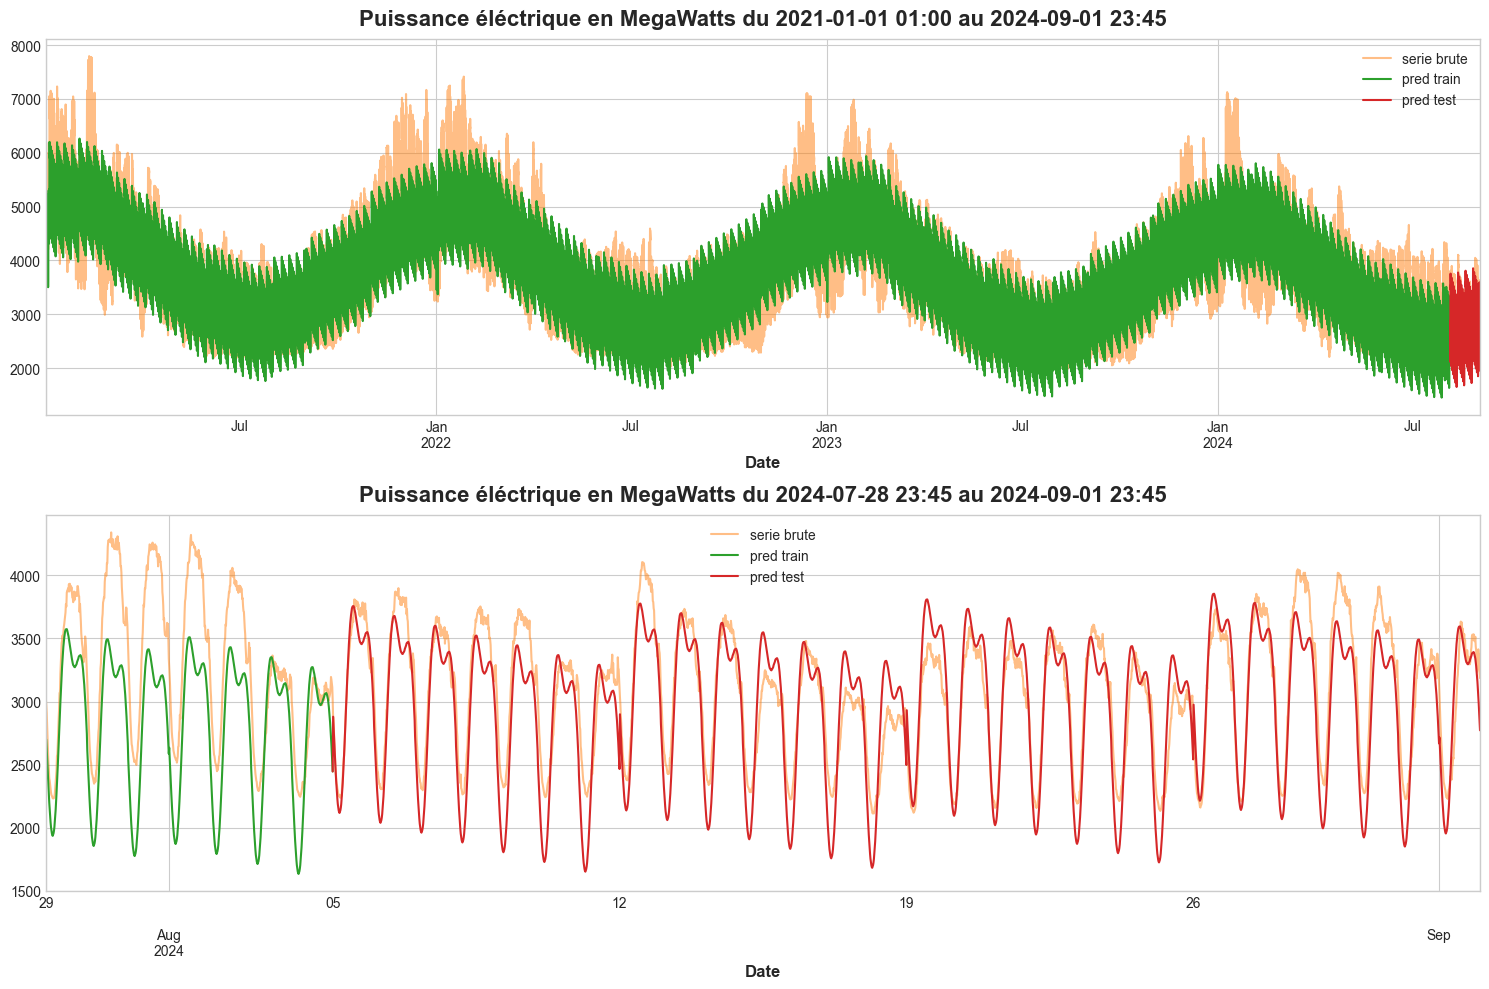

In [108]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_fourier_feature.columns)}")
metrics = compute_model(X_fourier_feature, y_time)

### Importance des Features dans la Régression Linéaire

On souhaite connaître l'**importance** et donc le **poids** de chaque feature dans cette régression. Pour cela, il suffit d'analyser les **coefficients** de la régression linéaire, à condition que les données soient **normalisées**.


<Axes: title={'center': 'Feature importance'}, ylabel='Feature'>

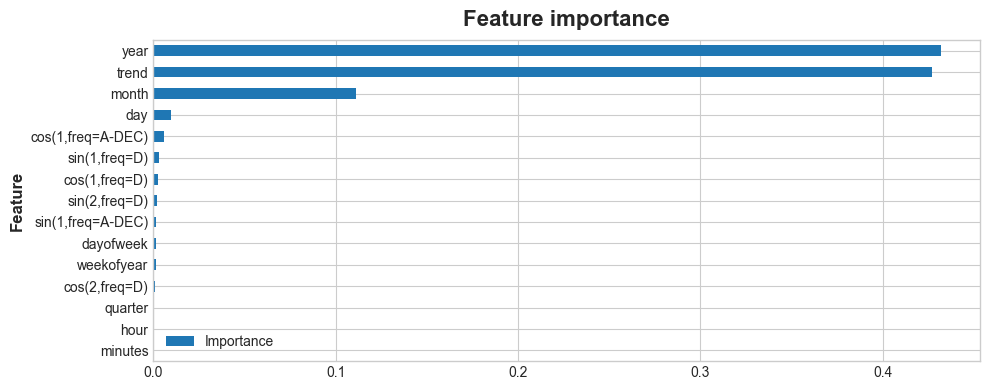

In [109]:
linReg_model = LinearRegression(fit_intercept=True)

X_fourier_feature_scale = pd.DataFrame(scale(X_fourier_feature.drop(columns='const')) , 
                                       columns=X_fourier_feature.drop(columns='const').columns , 
                                       index=X_fourier_feature.index)

X_fourier_feature_scale

linReg_model.fit(X_fourier_feature_scale, y_time)

# Récupérer l'importance des features (les coefficients du modèle)
importance = linReg_model.coef_
# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': linReg_model.feature_names_in_,
    'Importance': np.abs(importance.reshape(-1,))  # La magnitude du coefficient pour mesurer l'importance
})
importance_df.set_index("Feature", inplace=True)
importance_df = importance_df.sort_values(by='Importance', ascending=True)
(importance_df / importance_df.sum()).plot(kind='barh', figsize=(10,4), title='Feature importance')

### Sur X_fourier_lag_feature

Pour ce modèle les colonnes utilisées sont : 
['const', 'trend', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(1,freq=D)', 'cos(1,freq=D)', 'sin(2,freq=D)', 'cos(2,freq=D)', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 33.425, 'MSE': 2196.062, 'RMSE': 46.862, 'MAPE': 0.857, 'sMAPE': 0.857, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 201.181, 'MSE': 59335.505, 'RMSE': 243.589, 'MAPE': 6.881, 'sMAPE': 7.072, 'MSLE': 0.008, 'R_square': 0.767}


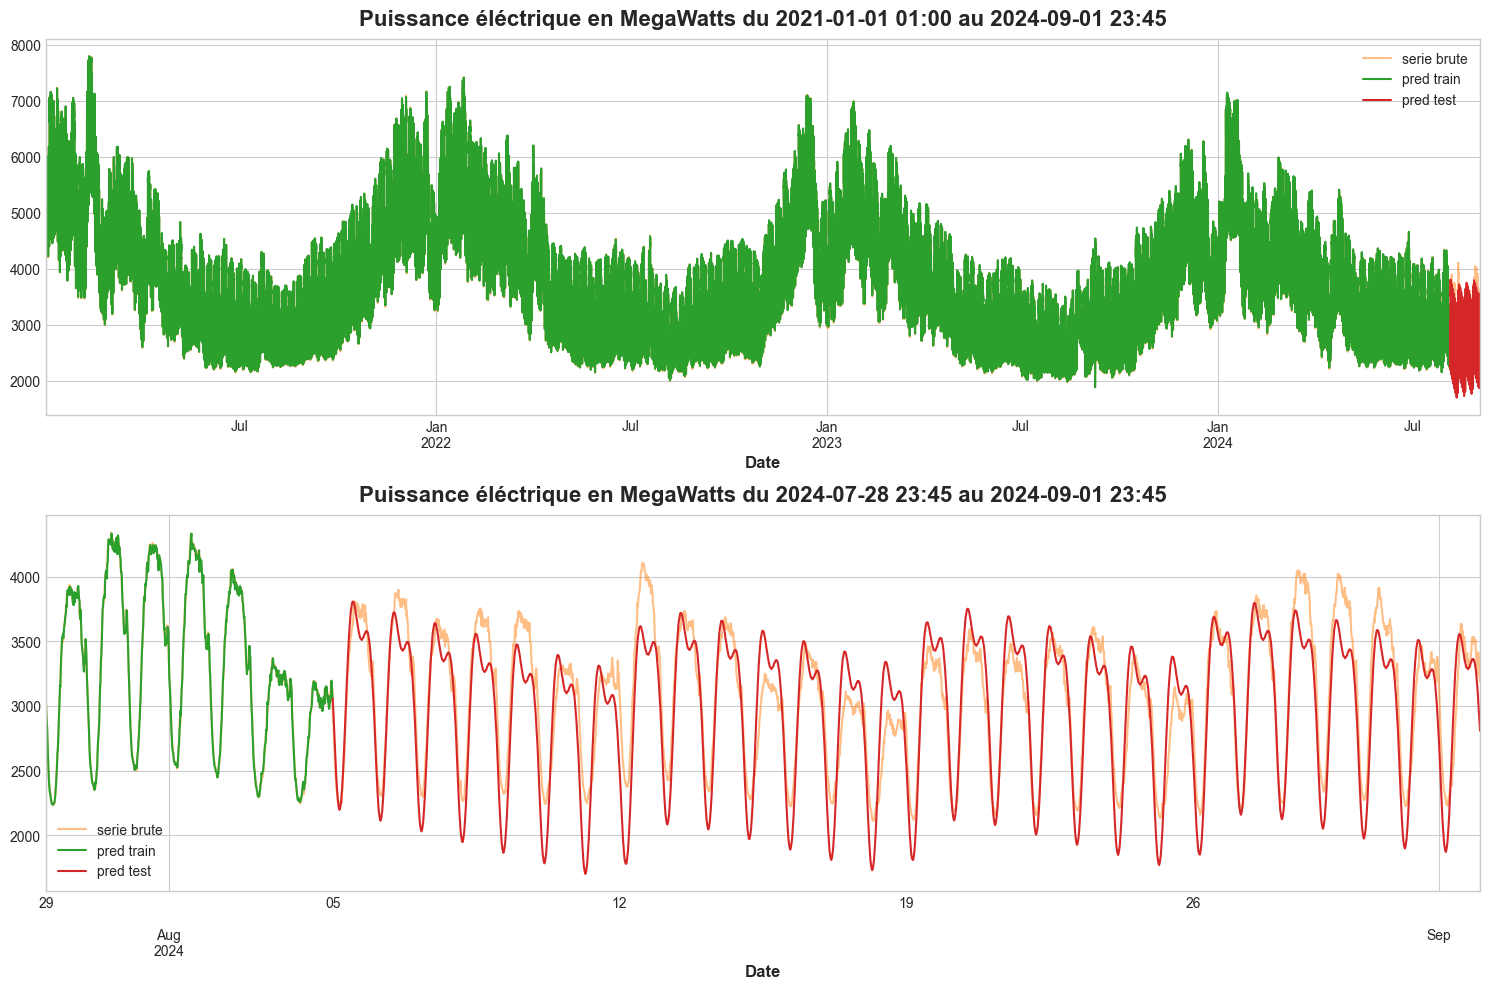

In [110]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_fourier_lag_feature.columns)}")
metrics = compute_model(X_fourier_lag_feature, y_time, iterative=True)

<Axes: title={'center': 'Feature importance'}, ylabel='Feature'>

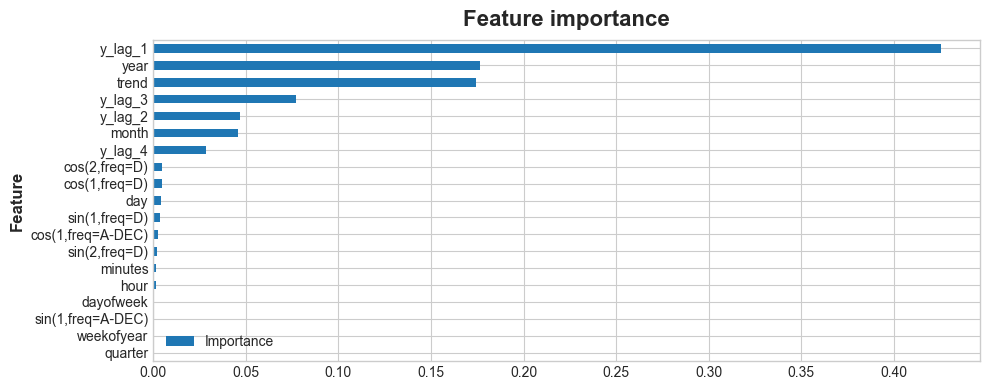

In [111]:
linReg_model = LinearRegression(fit_intercept=True)

X_fourier_lag_feature_scale = pd.DataFrame(scale(X_fourier_lag_feature.drop(columns='const')) , 
                                       columns=X_fourier_lag_feature.drop(columns='const').columns , 
                                       index=X_fourier_lag_feature.index)

linReg_model.fit(X_fourier_lag_feature_scale, y_time)

# Récupérer l'importance des features (les coefficients du modèle)
importance = linReg_model.coef_
# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': linReg_model.feature_names_in_,
    'Importance': np.abs(importance.reshape(-1,))  # La magnitude du coefficient pour mesurer l'importance
})
importance_df.set_index("Feature", inplace=True)
importance_df = importance_df.sort_values(by='Importance', ascending=True)
(importance_df / importance_df.sum()).plot(kind='barh', figsize=(10,4), title='Feature importance')

#### Recursive feature elimination

In [112]:
rec_features = X_fourier_lag_feature.drop(columns='quarter')
metrics = compute_model(rec_features, y_time, iterative=True, plot=False)

Métriques sur Train : {'MAE': 33.424, 'MSE': 2196.09, 'RMSE': 46.862, 'MAPE': 0.857, 'sMAPE': 0.857, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 202.582, 'MSE': 60014.777, 'RMSE': 244.979, 'MAPE': 6.929, 'sMAPE': 7.132, 'MSLE': 0.008, 'R_square': 0.764}


### Analyse des Coefficients de Régression

Notre R<sup>2</sup> est légèrement moins bon en ayant retiré la colonne dont la feature importance est la plus basse, c'est-à-dire la colonne *'quarter'*. Par conséquent, l'ensemble des variables de **X_fourier_lag_feature** sont pertinentes pour une modélisation linéaire.

## Modèle de Boosting XGBoost

In [113]:
xgb_model = XGBRegressor(n_estimators=500)

In [114]:
metric_dict = {}

for data_name , data_iterative in feature_dict.items():
    _data = data_iterative[0]
    _iterative = data_iterative[1]
    print(f"Metrics pour le jeu de données : {data_name}")
    metrics = compute_model(_data , y_time, model= xgb_model, iterative=_iterative, plot=False)
    metric_dict[data_name] = list( metrics.values() )

Metrics pour le jeu de données : X_fourier
Métriques sur Train : {'MAE': 48.143, 'MSE': 4319.557, 'RMSE': 65.723, 'MAPE': 1.272, 'sMAPE': 1.27, 'MSLE': 0.0, 'R_square': 0.996}
Métriques sur Test : {'MAE': 291.464, 'MSE': 141672.225, 'RMSE': 376.394, 'MAPE': 9.235, 'sMAPE': 9.566, 'MSLE': 0.015, 'R_square': 0.443}
Metrics pour le jeu de données : X_lags
Métriques sur Train : {'MAE': 32.14, 'MSE': 1992.148, 'RMSE': 44.633, 'MAPE': 0.814, 'sMAPE': 0.814, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 427.73, 'MSE': 254894.375, 'RMSE': 504.871, 'MAPE': 14.997, 'sMAPE': 14.271, 'MSLE': 0.03, 'R_square': -0.002}
Metrics pour le jeu de données : X_feature
Métriques sur Train : {'MAE': 37.843, 'MSE': 2700.323, 'RMSE': 51.965, 'MAPE': 0.983, 'sMAPE': 0.982, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 203.371, 'MSE': 64654.187, 'RMSE': 254.272, 'MAPE': 6.832, 'sMAPE': 6.596, 'MSLE': 0.007, 'R_square': 0.746}
Metrics pour le jeu de données : X_fourier_lag
Métriques 

In [115]:
df_feature_eval = pd.DataFrame(metric_dict , index=metrics.keys()).T
df_feature_eval.sort_values(by='R_square', ascending = False , inplace = True)
df_feature_eval

MAE         MSE     RMSE    MAPE   sMAPE   MSLE  \
X_fourier_lag_feature  157.983   41717.714  204.249   5.229   5.121  0.004   
X_feature              203.371   64654.187  254.272   6.832   6.596  0.007   
X_lag_feature          203.091   67521.494  259.849   6.719   6.405  0.006   
X_fourier_feature      235.672   91099.561  301.827   7.943   7.513  0.009   
X_fourier              291.464  141672.225  376.394   9.235   9.566  0.015   
X_fourier_lag          346.998  208371.243  456.477  11.243  11.087  0.021   
X_lags                 427.730  254894.375  504.871  14.997  14.271  0.030   

                       R_square  
X_fourier_lag_feature     0.836  
X_feature                 0.746  
X_lag_feature             0.735  
X_fourier_feature         0.642  
X_fourier                 0.443  
X_fourier_lag             0.181  
X_lags                   -0.002

### Sur X_feature

Pour ce modèle les colonnes utilisées sont : 
['year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 37.843, 'MSE': 2700.323, 'RMSE': 51.965, 'MAPE': 0.983, 'sMAPE': 0.982, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 203.371, 'MSE': 64654.187, 'RMSE': 254.272, 'MAPE': 6.832, 'sMAPE': 6.596, 'MSLE': 0.007, 'R_square': 0.746}


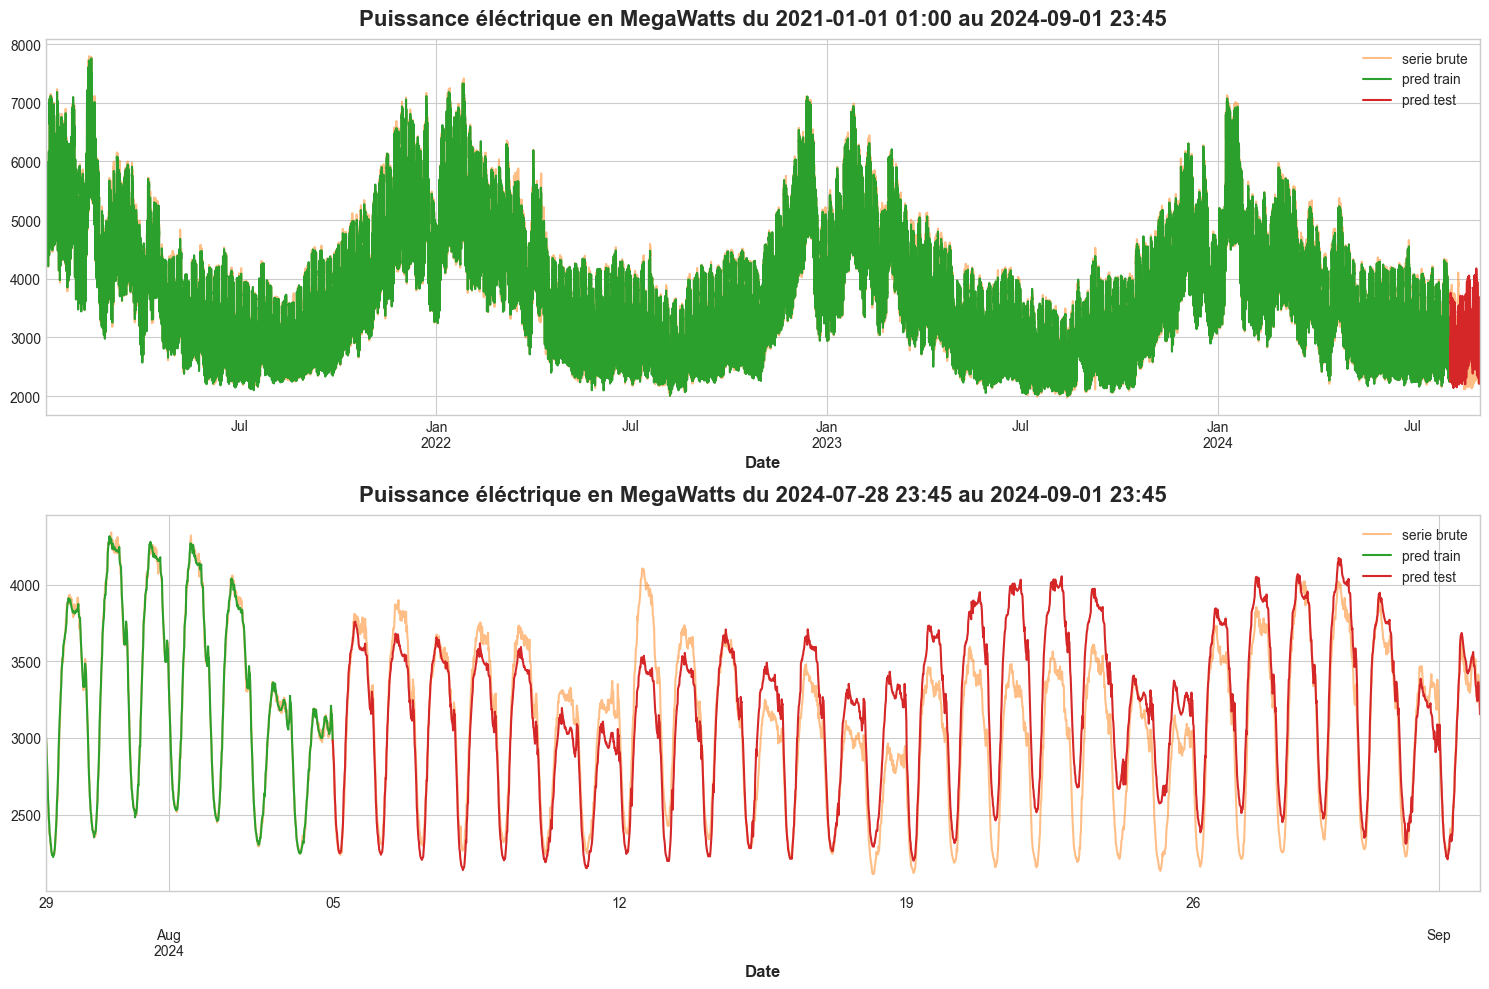

In [116]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_feature.columns)}")
metrics = compute_model(X_feature, y_time, model=xgb_model)

<Axes: title={'center': 'Feature importance'}>

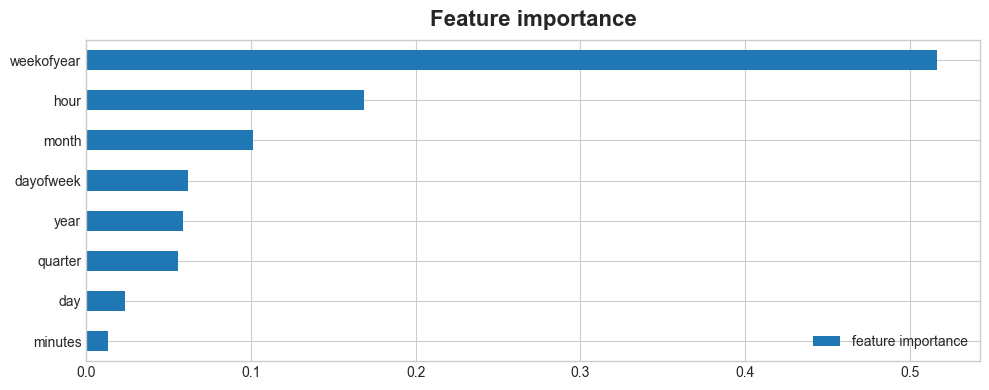

In [117]:
feature_importance_df = pd.DataFrame(xgb_model.feature_importances_ , index=xgb_model.feature_names_in_, columns=['feature importance'])
feature_importance_df.sort_values(by=['feature importance']).plot(kind='barh', figsize=(10,4), title='Feature importance')

### Sur X_fourier_feature

Pour ce modèle les colonnes utilisées sont : 
['const', 'trend', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(1,freq=D)', 'cos(1,freq=D)', 'sin(2,freq=D)', 'cos(2,freq=D)', 'year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 30.364, 'MSE': 1627.537, 'RMSE': 40.343, 'MAPE': 0.784, 'sMAPE': 0.783, 'MSLE': 0.0, 'R_square': 0.999}
Métriques sur Test : {'MAE': 235.672, 'MSE': 91099.561, 'RMSE': 301.827, 'MAPE': 7.943, 'sMAPE': 7.513, 'MSLE': 0.009, 'R_square': 0.642}


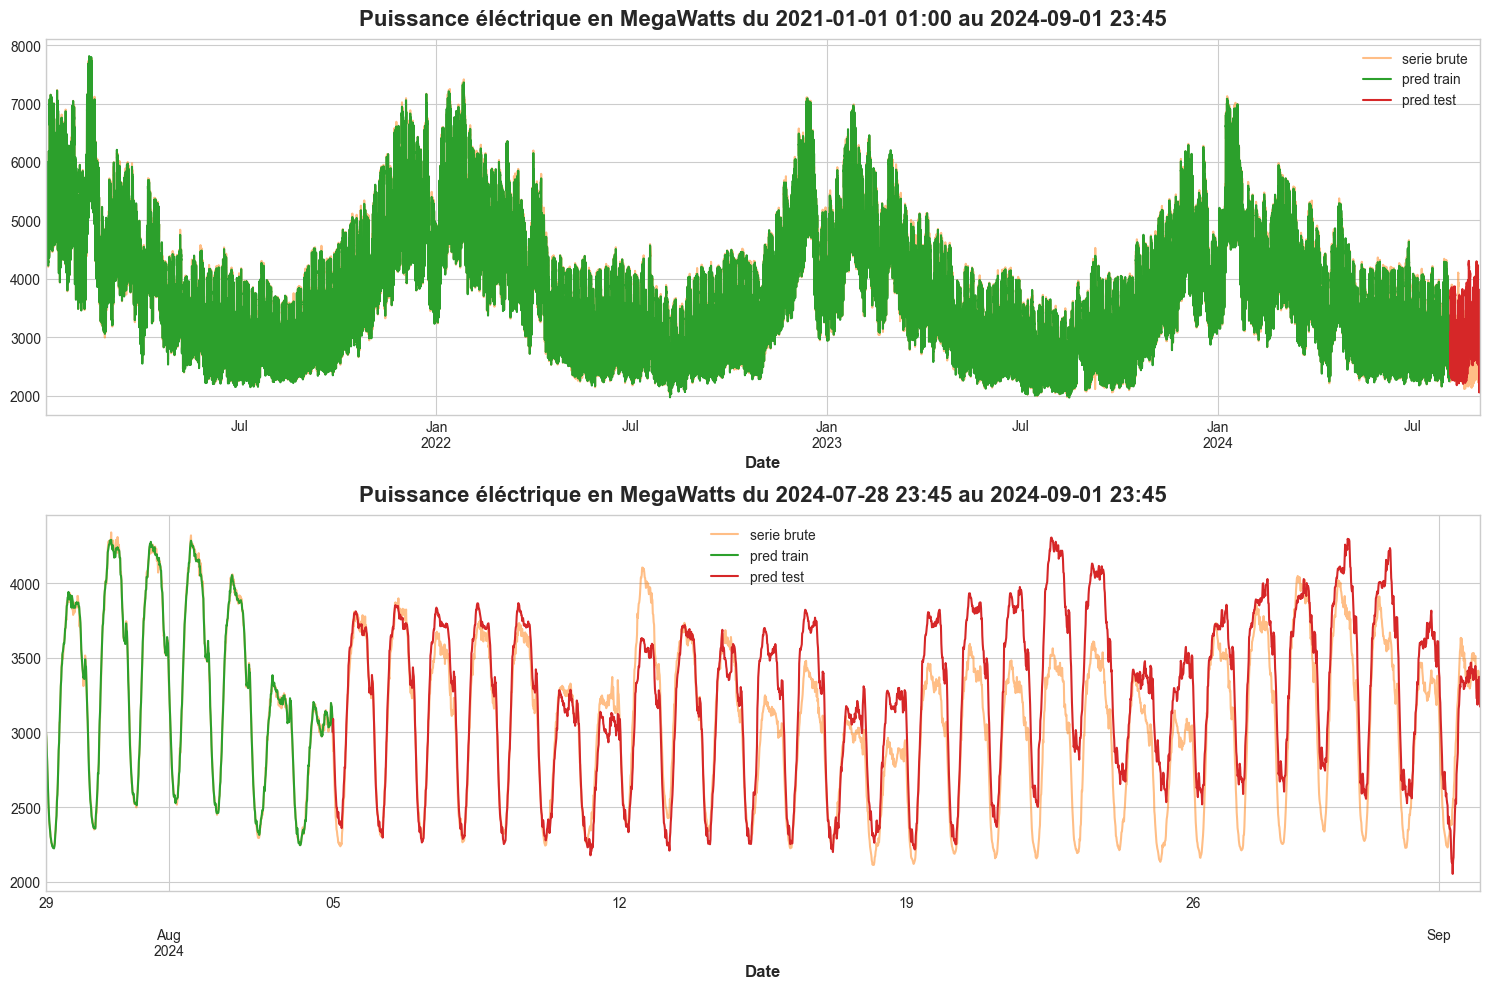

In [118]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_fourier_feature.columns)}")
metrics = compute_model(X_fourier_feature, y_time, model=xgb_model)

<Axes: title={'center': 'Feature importance'}>

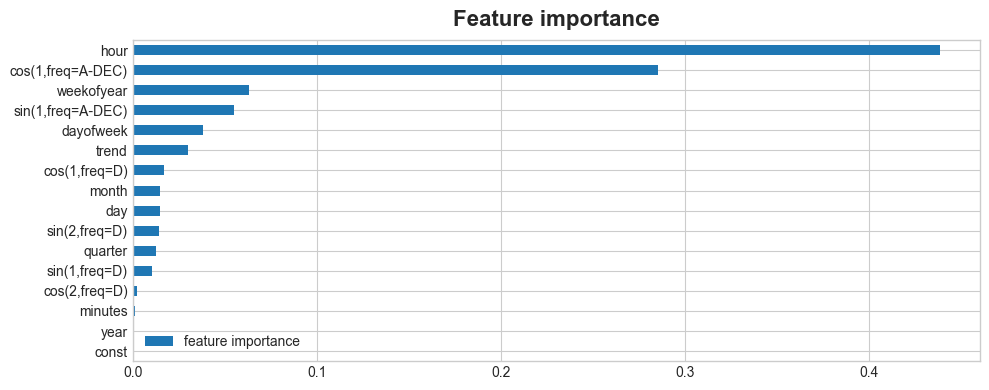

In [119]:
feature_importance_df = pd.DataFrame(xgb_model.feature_importances_ , index=xgb_model.feature_names_in_, columns=['feature importance'])
feature_importance_df.sort_values(by=['feature importance']).plot(kind='barh', figsize=(10,4), title='Feature importance')

### Sur X_lag_feature

Pour ce modèle les colonnes utilisées sont : 
['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 19.628, 'MSE': 693.223, 'RMSE': 26.329, 'MAPE': 0.505, 'sMAPE': 0.505, 'MSLE': 0.0, 'R_square': 0.999}
Métriques sur Test : {'MAE': 203.091, 'MSE': 67521.494, 'RMSE': 259.849, 'MAPE': 6.719, 'sMAPE': 6.405, 'MSLE': 0.006, 'R_square': 0.735}


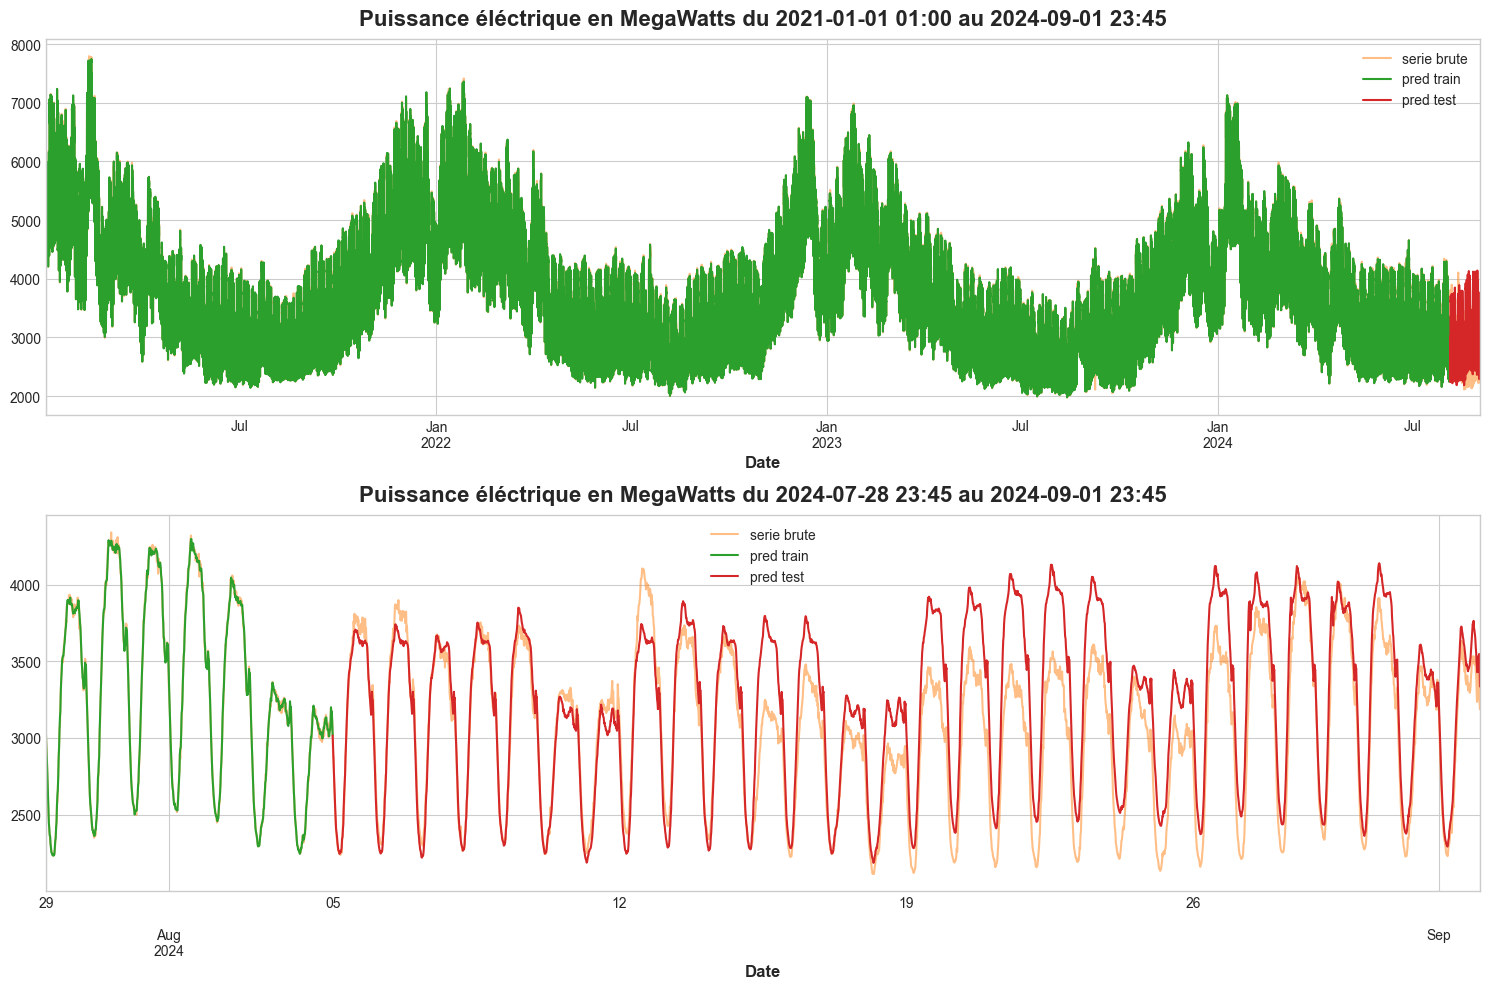

In [120]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_lag_feature.columns)}")
metrics = compute_model(X_lag_feature, y_time, model=xgb_model, iterative=True)

<Axes: title={'center': 'Feature importance'}>

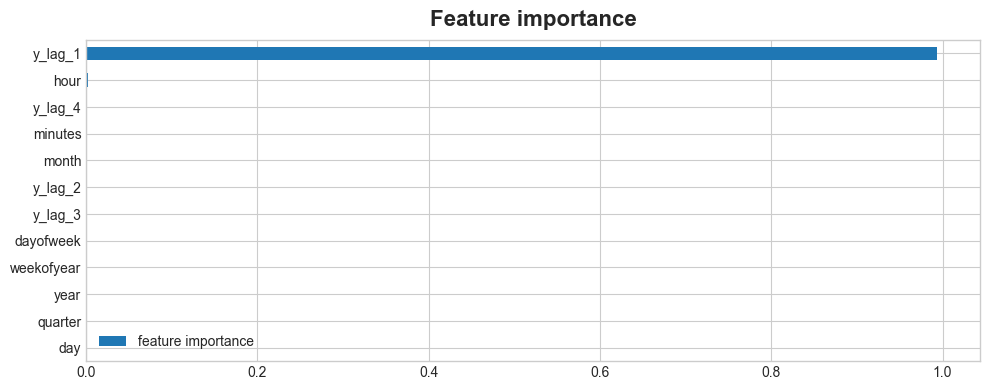

In [121]:
feature_importance_df = pd.DataFrame(xgb_model.feature_importances_ , index=xgb_model.feature_names_in_, columns=['feature importance'])
feature_importance_df.sort_values(by=['feature importance']).plot(kind='barh', figsize=(10,4), title='Feature importance')

### Sur X_fourier_lag_feature

Pour ce modèle les colonnes utilisées sont : 
['const', 'trend', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(1,freq=D)', 'cos(1,freq=D)', 'sin(2,freq=D)', 'cos(2,freq=D)', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'year', 'quarter', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'weekofyear']
Métriques sur Train : {'MAE': 18.496, 'MSE': 604.145, 'RMSE': 24.579, 'MAPE': 0.477, 'sMAPE': 0.477, 'MSLE': 0.0, 'R_square': 0.999}
Métriques sur Test : {'MAE': 157.983, 'MSE': 41717.714, 'RMSE': 204.249, 'MAPE': 5.229, 'sMAPE': 5.121, 'MSLE': 0.004, 'R_square': 0.836}


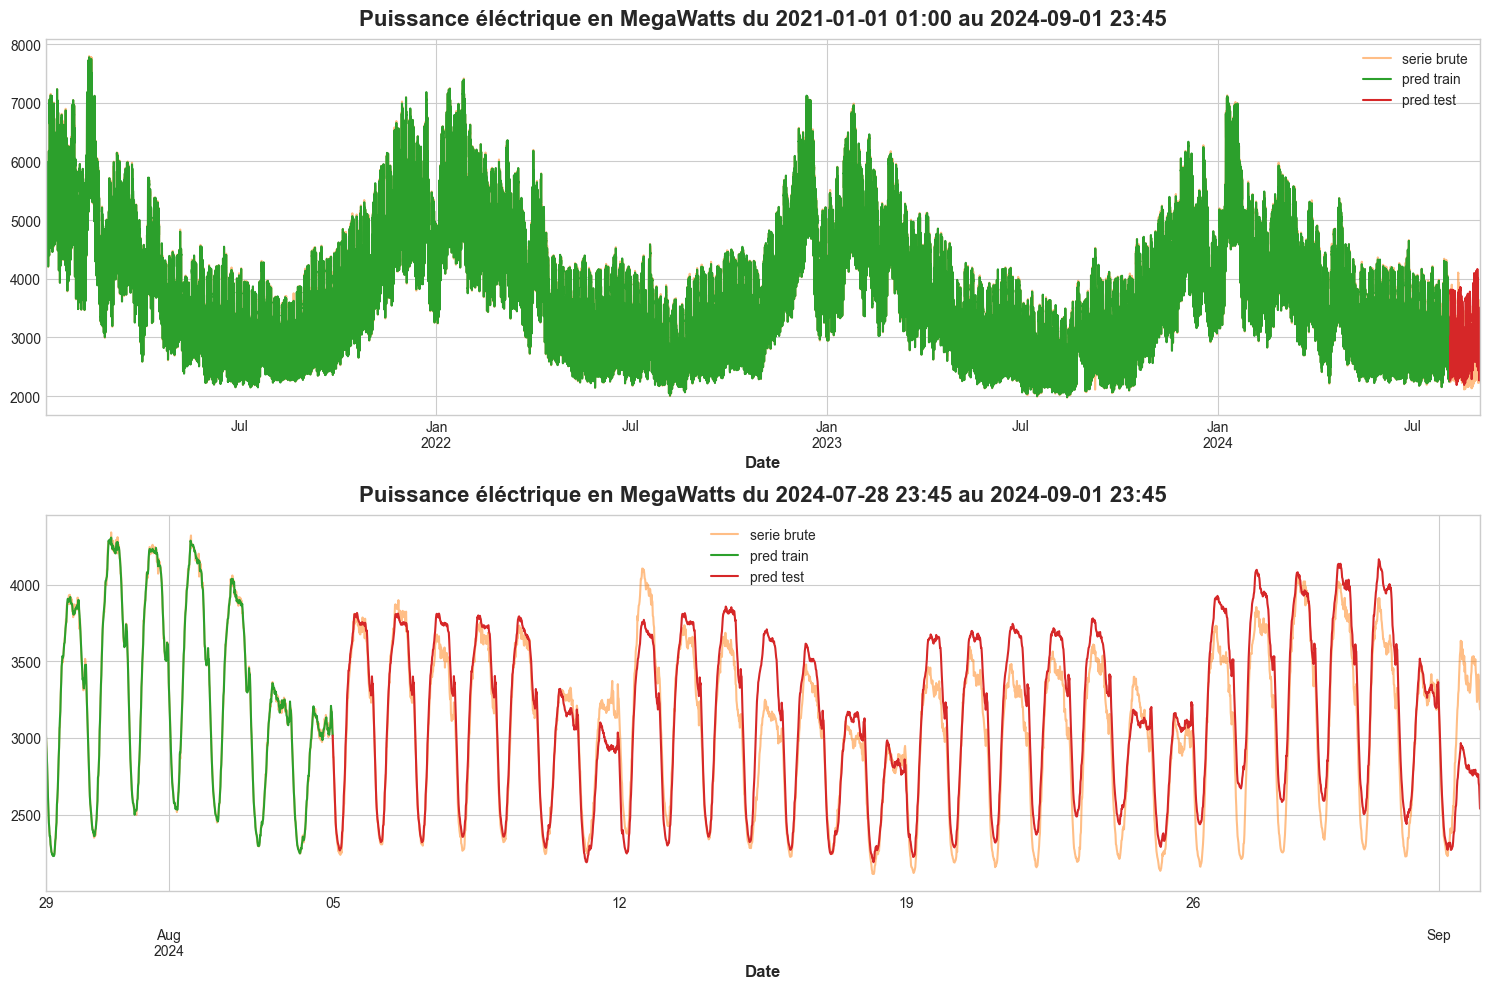

In [122]:
print(f"Pour ce modèle les colonnes utilisées sont : \n{list(X_fourier_lag_feature.columns)}")
metrics = compute_model(X_fourier_lag_feature, y_time, model=xgb_model, iterative=True)

<Axes: title={'center': 'Feature importance'}>

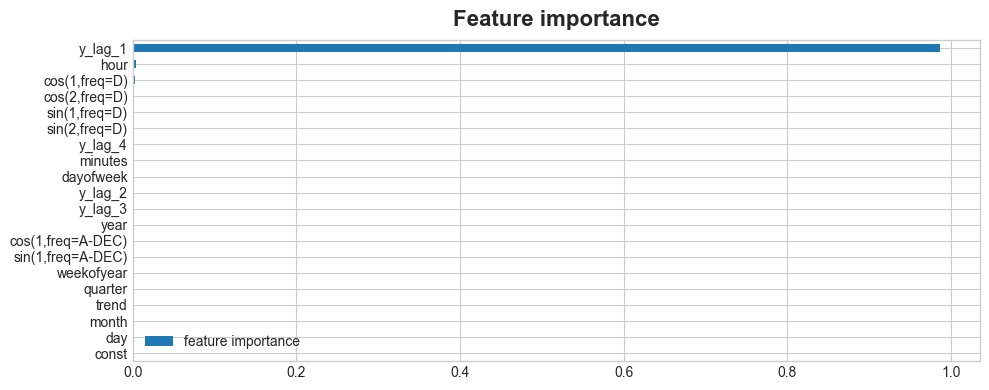

In [123]:
feature_importance_df = pd.DataFrame(xgb_model.feature_importances_ , index=xgb_model.feature_names_in_, columns=['feature importance'])
feature_importance_df.sort_values(by=['feature importance']).plot(kind='barh', figsize=(10,4), title='Feature importance')

## Hyperparamètres

On retient 4 configurations pour la prédiction de nos données :

- **Avec le modèle de régression linéaire :**
  - *X_fourier_feature*
  - *X_fourier_feature_lag*

- **Avec le modèle de boosting XGBoost :**
  - *X_feature*
  - *X_fourier_feature*

Comme nous avons pu l'observer, les modèles de boosting affectent un poids très fort à la variable *y_lag_1*. Cela peut avoir pour conséquence une divergence des prédictions par rapport aux vraies valeurs de la série si celles-ci sont effectuées sur du long terme à cause du cumul d'erreur sur les prédictions itératives.  
De plus, la prédiction itérative, qui met à jour les lags au fur et à mesure, est coûteuse en temps et en calculs. Nous décidons alors de ne pas retenir les variables de lag pour le modèle de boosting.  
On cherche maintenant les *hyperparamètres* qui permettent de réguler au mieux nos modèles afin d'améliorer nos prédictions.

### Cross validation

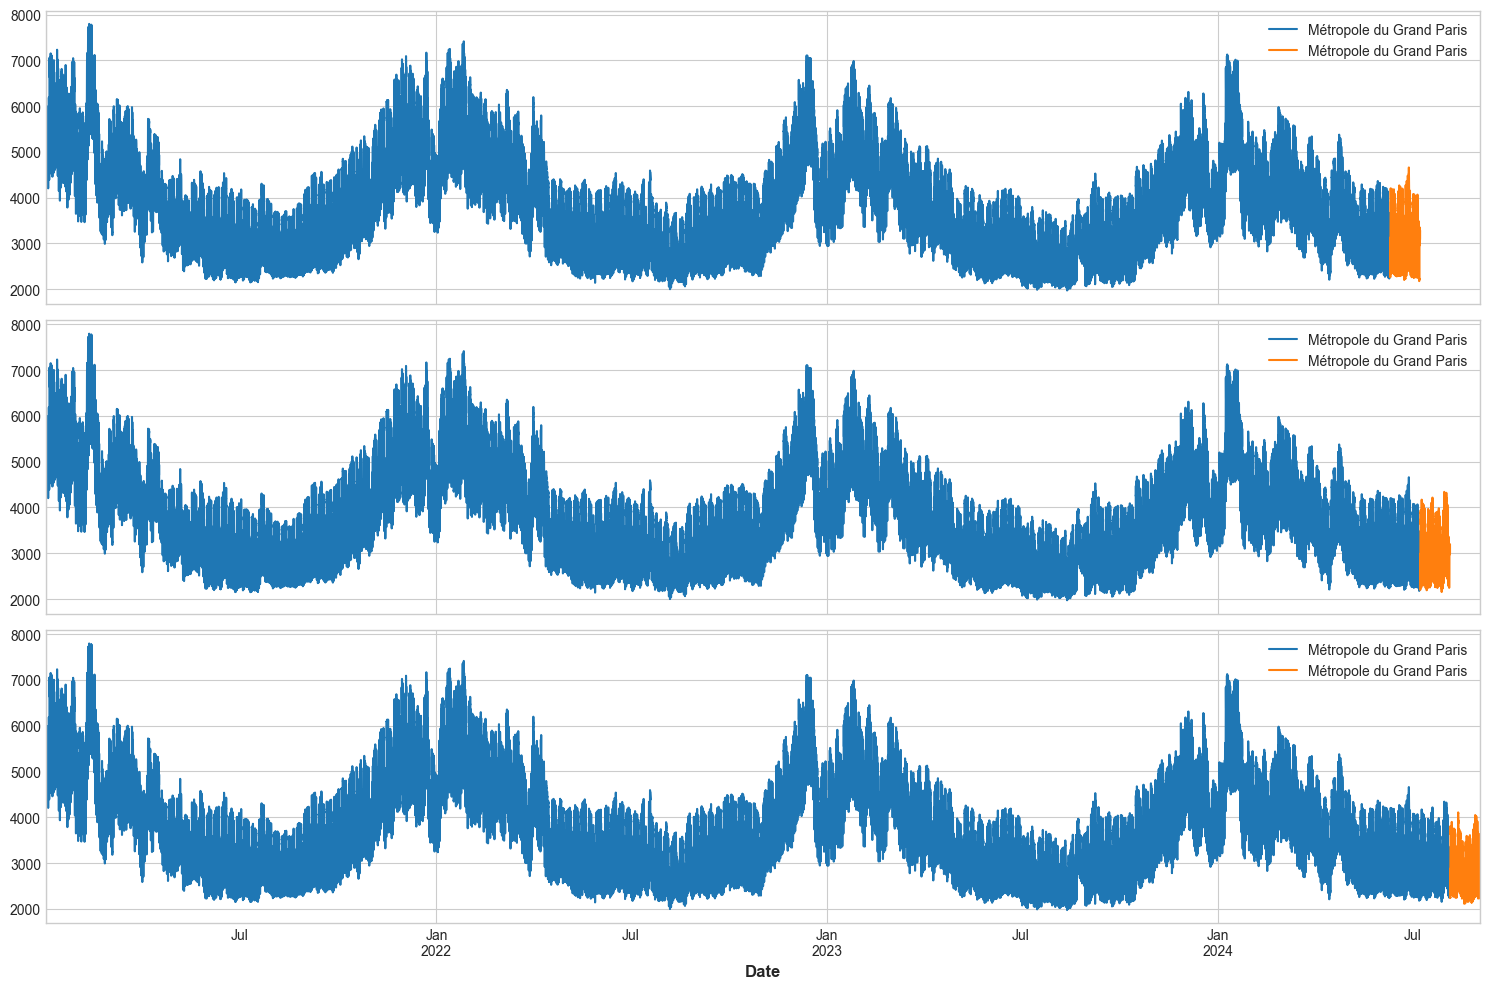

In [124]:
y_splits = TimeSeriesSplit(n_splits=3, test_size=4*24*7*4)

fig , ax_list = plt.subplots(nrows=3, ncols=1, sharex=True)

ax_idx = 0 
for train_idx , val_idx in y_splits.split(y_time):
    train = y_time.iloc[train_idx]
    test = y_time.iloc[val_idx]
    train.plot(ax=ax_list[ax_idx])
    test.plot(ax=ax_list[ax_idx])
    ax_idx += 1

### **Pour la régression linéaire** 
#### Sur X_fourier_lag_feature

In [125]:
models = {
    'Ridge': Ridge(fit_intercept=False),
    'Lasso': Lasso(fit_intercept=False),
    'ElasticNet': ElasticNet(fit_intercept=False)
}

# Définir la grille de recherche
param_grid = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
}

# Pour stocker les meilleurs modèles
best_models = {}

# Boucle sur chaque modèle et recherche de meilleurs paramètres
for model_name in models:
    grid_search = GridSearchCV(
        estimator=models[model_name], 
        param_grid=param_grid[model_name], 
        cv=y_splits, 
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_fourier_lag_feature, y_time.squeeze())  # Remplacer par vos données d'entraînement
    best_models[model_name] = grid_search.best_estimator_

# Afficher les meilleurs paramètres et évaluer les modèles
for model_name, model in best_models.items():
    print(f"{model_name} - Meilleurs paramètres : {model}")

c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.140e+08, tolerance: 2.072e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.240e+08, tolerance: 2.103e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Ridge - Meilleurs paramètres : Ridge(alpha=100, fit_intercept=False)
Lasso - Meilleurs paramètres : Lasso(alpha=1, fit_intercept=False)
ElasticNet - Meilleurs paramètres : ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.2)


In [126]:
metrics = compute_model(X_fourier_lag_feature, y_time, model=Ridge(alpha=100, fit_intercept=False), iterative=True, plot=False)

Métriques sur Train : {'MAE': 33.426, 'MSE': 2196.44, 'RMSE': 46.866, 'MAPE': 0.857, 'sMAPE': 0.857, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 224.951, 'MSE': 73597.84, 'RMSE': 271.289, 'MAPE': 7.699, 'sMAPE': 8.067, 'MSLE': 0.01, 'R_square': 0.711}


In [127]:
metrics = compute_model(X_fourier_lag_feature, y_time, model=Lasso(alpha=1, fit_intercept=False), iterative=True, plot=False)

c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.329e+08, tolerance: 2.132e+08
  model = cd_fast.enet_coordinate_descent(


Métriques sur Train : {'MAE': 34.82, 'MSE': 2348.052, 'RMSE': 48.457, 'MAPE': 0.89, 'sMAPE': 0.89, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 61680.788, 'MSE': 10528844387.126, 'RMSE': 102610.157, 'MAPE': 2043.902, 'sMAPE': 134.141, 'MSLE': 6.801, 'R_square': -41368.224}


In [128]:
metrics = compute_model(X_fourier_lag_feature, y_time, model=ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.2), iterative=True, plot=False)

Métriques sur Train : {'MAE': 34.776, 'MSE': 2341.699, 'RMSE': 48.391, 'MAPE': 0.887, 'sMAPE': 0.888, 'MSLE': 0.0, 'R_square': 0.998}
Métriques sur Test : {'MAE': 168.917, 'MSE': 44633.262, 'RMSE': 211.266, 'MAPE': 5.557, 'sMAPE': 5.582, 'MSLE': 0.005, 'R_square': 0.825}


#### Sur X_fourier_feature

In [129]:
models = {
    'Ridge': Ridge(fit_intercept=False),
    'Lasso': Lasso(fit_intercept=False),
    'ElasticNet': ElasticNet(fit_intercept=False)
}

# Définir la grille de recherche
param_grid = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
}

# Pour stocker les meilleurs modèles
best_models = {}

# Boucle sur chaque modèle et recherche de meilleurs paramètres
for model_name in models:
    grid_search = GridSearchCV(
        estimator=models[model_name], 
        param_grid=param_grid[model_name], 
        cv=y_splits, 
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_fourier_feature, y_time.squeeze())  # Remplacer par vos données d'entraînement
    best_models[model_name] = grid_search.best_estimator_

# Afficher les meilleurs paramètres et évaluer les modèles
for model_name, model in best_models.items():
    print(f"{model_name} - Meilleurs paramètres : {model}")

c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+10, tolerance: 2.072e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+10, tolerance: 2.103e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\amaur\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Ridge - Meilleurs paramètres : Ridge(alpha=100, fit_intercept=False)
Lasso - Meilleurs paramètres : Lasso(alpha=10, fit_intercept=False)
ElasticNet - Meilleurs paramètres : ElasticNet(alpha=1, fit_intercept=False)


In [130]:
metrics = compute_model(X_fourier_feature, y_time, model=Ridge(alpha=100, fit_intercept=False), plot=False)

Métriques sur Train : {'MAE': 373.898, 'MSE': 231211.721, 'RMSE': 480.845, 'MAPE': 9.546, 'sMAPE': 9.466, 'MSLE': 0.014, 'R_square': 0.798}
Métriques sur Test : {'MAE': 238.303, 'MSE': 81638.64, 'RMSE': 285.725, 'MAPE': 8.158, 'sMAPE': 8.592, 'MSLE': 0.012, 'R_square': 0.679}


In [131]:
metrics = compute_model(X_fourier_feature, y_time, model=Lasso(alpha=10, fit_intercept=False), plot=False)

Métriques sur Train : {'MAE': 375.151, 'MSE': 234568.646, 'RMSE': 484.323, 'MAPE': 9.553, 'sMAPE': 9.445, 'MSLE': 0.014, 'R_square': 0.795}
Métriques sur Test : {'MAE': 215.393, 'MSE': 66431.555, 'RMSE': 257.743, 'MAPE': 7.286, 'sMAPE': 7.572, 'MSLE': 0.009, 'R_square': 0.739}


In [132]:
metrics = compute_model(X_fourier_feature, y_time, model=ElasticNet(alpha=1, fit_intercept=False), plot=False)

Métriques sur Train : {'MAE': 503.516, 'MSE': 418076.582, 'RMSE': 646.588, 'MAPE': 13.052, 'sMAPE': 12.714, 'MSLE': 0.025, 'R_square': 0.635}
Métriques sur Test : {'MAE': 270.364, 'MSE': 107253.1, 'RMSE': 327.495, 'MAPE': 9.492, 'sMAPE': 8.933, 'MSLE': 0.012, 'R_square': 0.579}


On ne retiendra que le modèle de regression régularisée à l'aide l'ElasticNet sur les données X_fourier_lag_feature

### **Pour XGBoost**
#### Sur X_feature

In [133]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [200, 500, 700, 900],  # 200
    'max_depth': [3, 5, 7],  # 7
    'learning_rate': [0.01],  # 0.01
}

# Configuration du modèle XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # ou une autre métrique adaptée
    cv=y_splits,
    n_jobs=-1
)

# Lancement de la recherche d'hyperparamètres
grid_search.fit(X_feature, y_time)

# Afficher les meilleurs paramètres et évaluer les modèles
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 900}


In [151]:
# xgb_model = XGBRegressor(n_estimators = 700, max_depth = 5, learning_rate = 0.01)

metrics = compute_model(X_feature, y_time, model=xgb_model, plot=False)

Métriques sur Train : {'MAE': 112.901, 'MSE': 24198.918, 'RMSE': 155.56, 'MAPE': 2.837, 'sMAPE': 2.826, 'MSLE': 0.001, 'R_square': 0.979}
Métriques sur Test : {'MAE': 162.606, 'MSE': 42838.537, 'RMSE': 206.975, 'MAPE': 5.427, 'sMAPE': 5.245, 'MSLE': 0.004, 'R_square': 0.832}


#### Sur X_fourier_feature

In [135]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [200, 500, 700, 900],  # 200
    'max_depth': [3, 5, 7],  # 7
    'learning_rate': [0.01],  # 0.01
}

# Configuration du modèle XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # ou une autre métrique adaptée
    cv=y_splits,
    n_jobs=-1
)

# Lancement de la recherche d'hyperparamètres
grid_search.fit(X_fourier_feature, y_time)

# Afficher les meilleurs paramètres et évaluer les modèles
print(f"Meilleurs paramètres : {grid_search.best_params_}")

Meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 900}


Métriques sur Train : {'MAE': 100.076, 'MSE': 18369.569, 'RMSE': 135.534, 'MAPE': 2.53, 'sMAPE': 2.522, 'MSLE': 0.001, 'R_square': 0.984}
Métriques sur Test : {'MAE': 162.906, 'MSE': 41202.528, 'RMSE': 202.984, 'MAPE': 5.382, 'sMAPE': 5.209, 'MSLE': 0.004, 'R_square': 0.838}


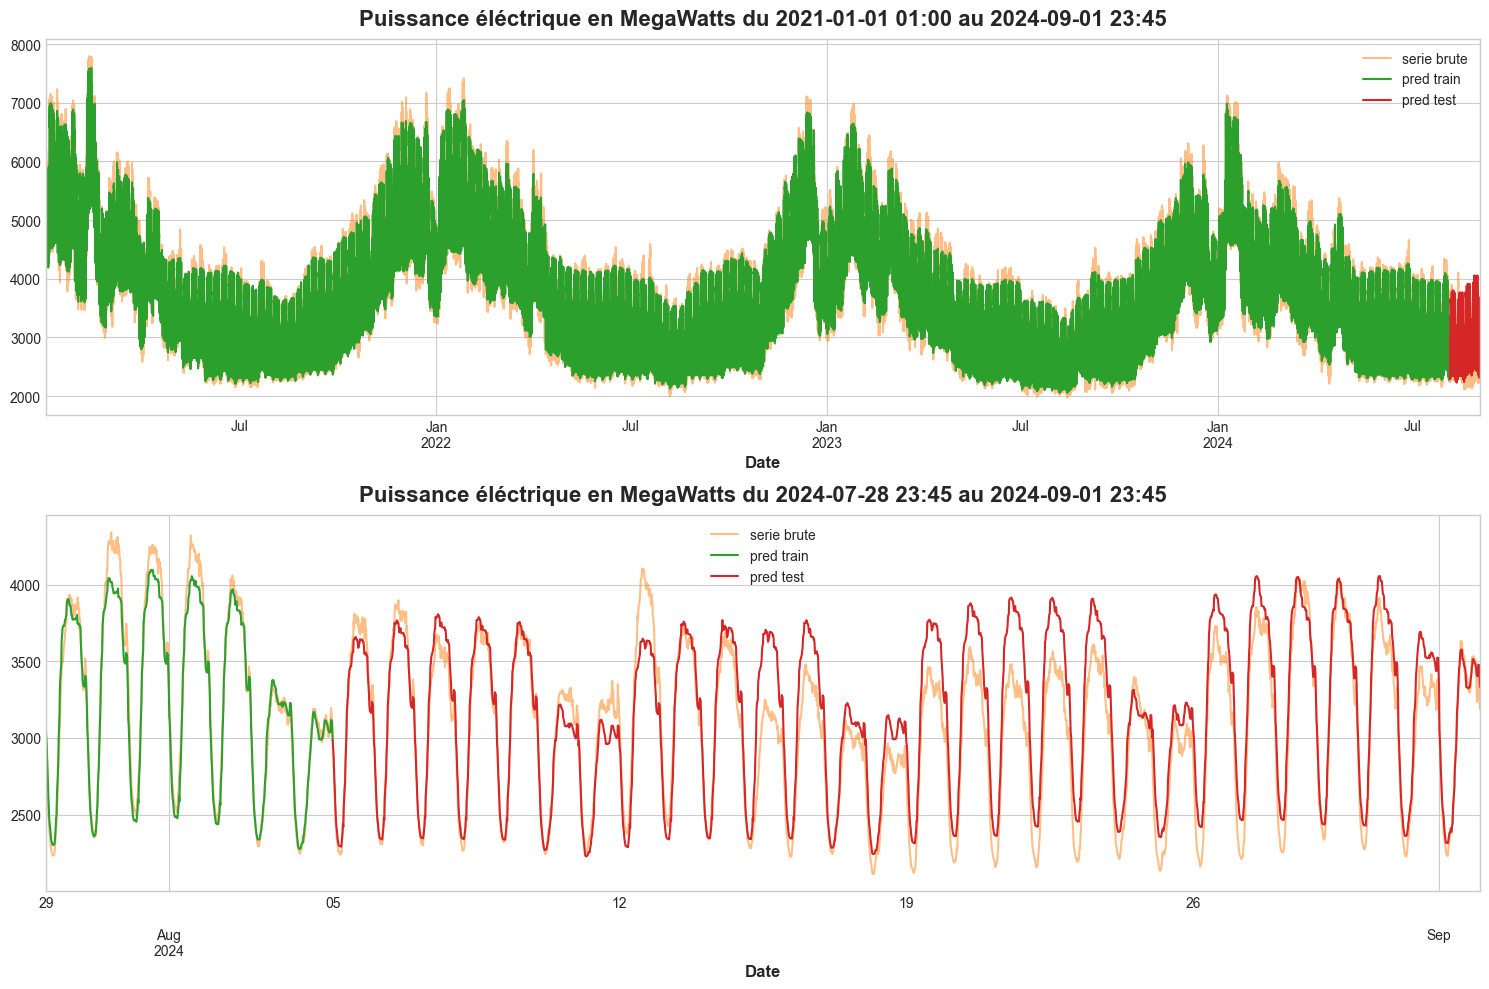

In [152]:
xgb_model = XGBRegressor(n_estimators = 700, max_depth = 7, learning_rate = 0.01)

metrics = compute_model(X_fourier_feature, y_time, model=xgb_model, plot=True)

## Conclusion

Les meilleures prévisions sur notre série temporelle sont :

- **Avec XGBoost :**
  - Sur **X_fourier_lag_feature**, nous obtenons un *R²* de **0.85**. Cependant, on observe un fort sur-apprentissage sur le jeu d'entraînement, ce qui pourrait mener à une mauvaise généralisation sur les données à prédire. De plus les prédictions itératives engendre un cumul d'erreur qui peuvent mener à une divergence des prédictions.
  - Sur **X_fourier_feature** avec régularisation du modèle XGBoost, le *R²* est de **0.84**. C'est **le modèle que nous retiendrons par la suite**.

- **Avec la Régression Linéaire :**
  - Sur **X_fourier_lag_feature** avec régularisation ElasticNet, le *R²* est de **0.82**, mais il y a un sur-apprentissage sur le jeu d'entraînement à cause des différents lags.
  - Sur **X_fourier_feature**, nous obtenons un *R²* de **0.74**.

Les prédictions itératives utilisant des lags sont malheureusement coûteuses en temps de calcul.  
Par conséquent, le modèle retenu est celui de XGBoost sur les données *X_fourier_feature*.


Métriques sur Train : {'MAE': 100.076, 'MSE': 18369.569, 'RMSE': 135.534, 'MAPE': 2.53, 'sMAPE': 2.522, 'MSLE': 0.001, 'R_square': 0.984}
Métriques sur Test : {'MAE': 162.906, 'MSE': 41202.528, 'RMSE': 202.984, 'MAPE': 5.382, 'sMAPE': 5.209, 'MSLE': 0.004, 'R_square': 0.838}


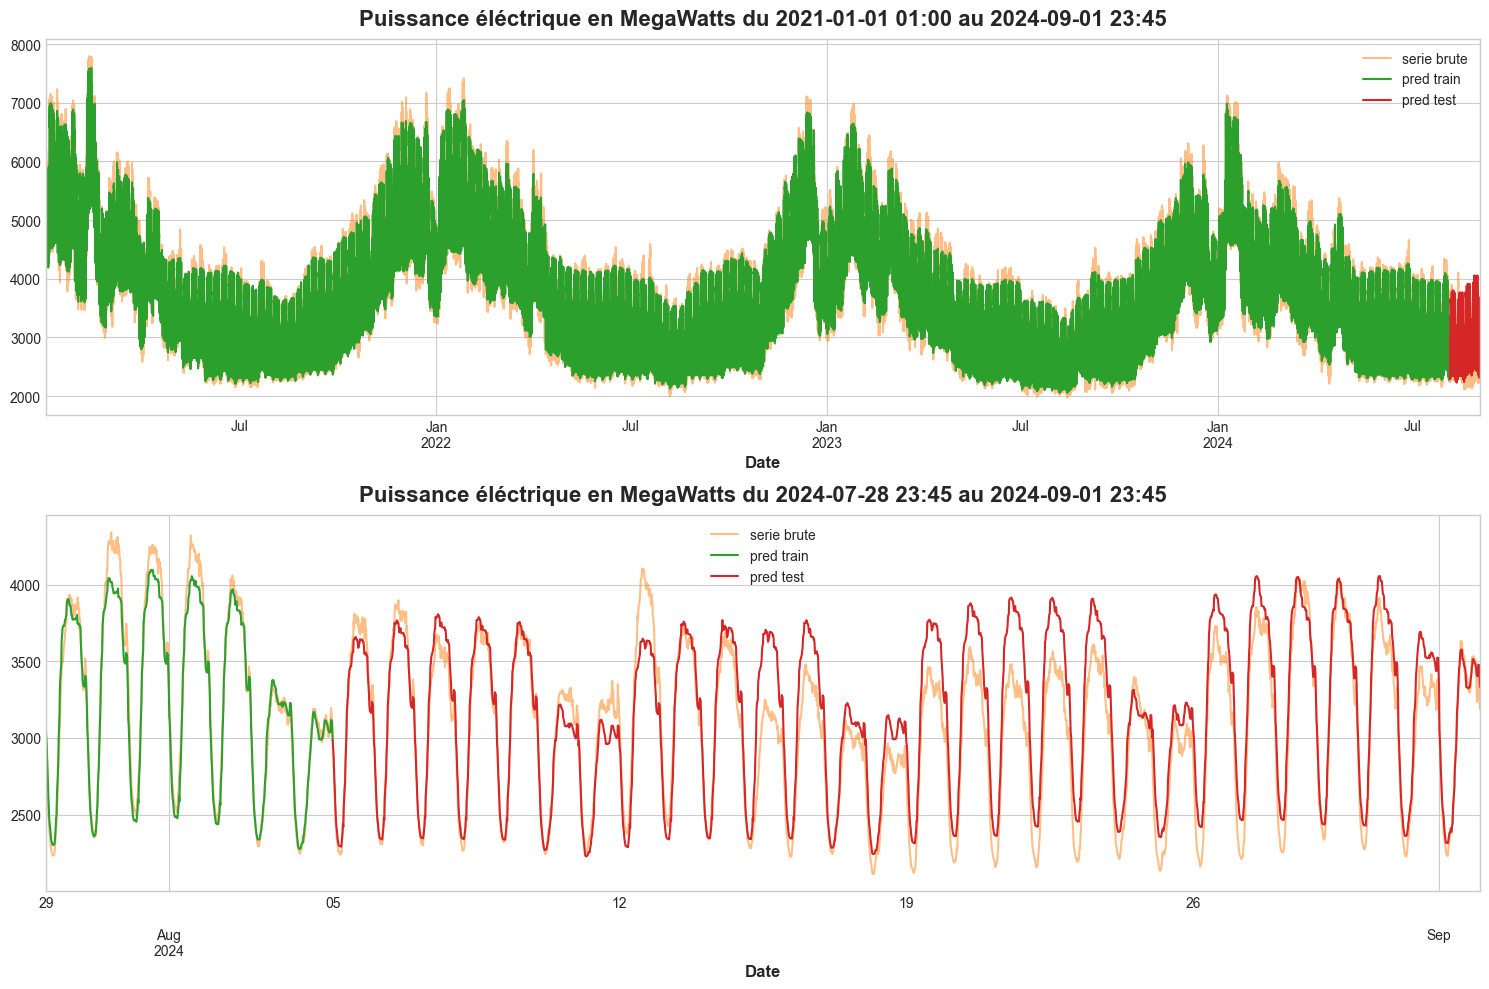

In [137]:
xgb_model = XGBRegressor(n_estimators = 700, max_depth = 7, learning_rate = 0.01)

metrics = compute_model(X_fourier_feature, y_time, model=xgb_model)

## Utilisation de Prophet : l'algorithme de Facebook

In [66]:
from prophet import Prophet

prophet_data = y_time.copy()
prophet_data = (prophet_data
                .reset_index()
                .rename(columns={'Date' : 'ds' , 'Métropole du Grand Paris' : 'y'})
)
prophet_data['ds'] = prophet_data['ds'].dt.to_timestamp()
prophet_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128636 entries, 0 to 128635
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      128636 non-null  datetime64[ns]
 1   y       128636 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


In [67]:
WEEK_TO_FORECAST = 4

END_TRAIN_DATE = y_time.index[-1] - timedelta(weeks=WEEK_TO_FORECAST) # Soustraction de N semaines
END_TRAIN_DATE = END_TRAIN_DATE.strftime('%Y-%m-%d %H:%M') # Conversion en chaîne de caractères

prophet_train = prophet_data.loc[prophet_data.loc[ : ,'ds'] < END_TRAIN_DATE]
prophet_test = prophet_data.loc[prophet_data.loc[ : ,'ds'] >= END_TRAIN_DATE]

In [70]:
# Création et ajustement du modèle Prophet
model = Prophet()
model.fit(prophet_train)

18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:55 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
prophet_train_to_predict = prophet_train.drop(columns='y')
prophet_test_to_predict = prophet_test.drop(columns='y')

In [72]:
forecast_train = model.predict(prophet_train_to_predict)
forecast_test = model.predict(prophet_test_to_predict)

prophet_pred_train = forecast_train[['ds' , 'yhat']].set_index('ds').squeeze()
prophet_pred_test = forecast_test[['ds' , 'yhat']].set_index('ds').squeeze()

forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds         yhat   yhat_lower   yhat_upper
0    2024-08-04 23:45:00  2789.737222  2279.842161  3257.700772
1    2024-08-05 00:00:00  2740.952535  2244.247354  3194.629487
2    2024-08-05 00:15:00  2689.616070  2197.761626  3172.828762
3    2024-08-05 00:30:00  2635.533245  2150.360158  3135.788105
4    2024-08-05 00:45:00  2578.694873  2065.736732  3027.387555
...                  ...          ...          ...          ...
2684 2024-09-01 22:45:00  3443.548022  2948.334221  3922.275284
2685 2024-09-01 23:00:00  3401.554707  2918.220220  3900.873983
2686 2024-09-01 23:15:00  3358.515941  2862.883965  3834.367715
2687 2024-09-01 23:30:00  3314.065641  2850.502494  3818.175592
2688 2024-09-01 23:45:00  3267.791058  2770.315095  3740.213540

[2689 rows x 4 columns]

C:\Users\amaur\AppData\Local\Temp\ipykernel_3060\3725220106.py:25: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred) / y)) * 100
C:\Users\amaur\AppData\Local\Temp\ipykernel_3060\3725220106.py:25: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


Métriques sur Train : {'MAE': 275.323, 'MSE': 140552.075, 'RMSE': 374.903, 'MAPE': nan, 'sMAPE': nan, 'MSLE': 0.008, 'R_square': 0.877}
Métriques sur Test : {'MAE': 296.053, 'MSE': 123905.549, 'RMSE': 352.002, 'MAPE': nan, 'sMAPE': nan, 'MSLE': 0.013, 'R_square': 0.513}


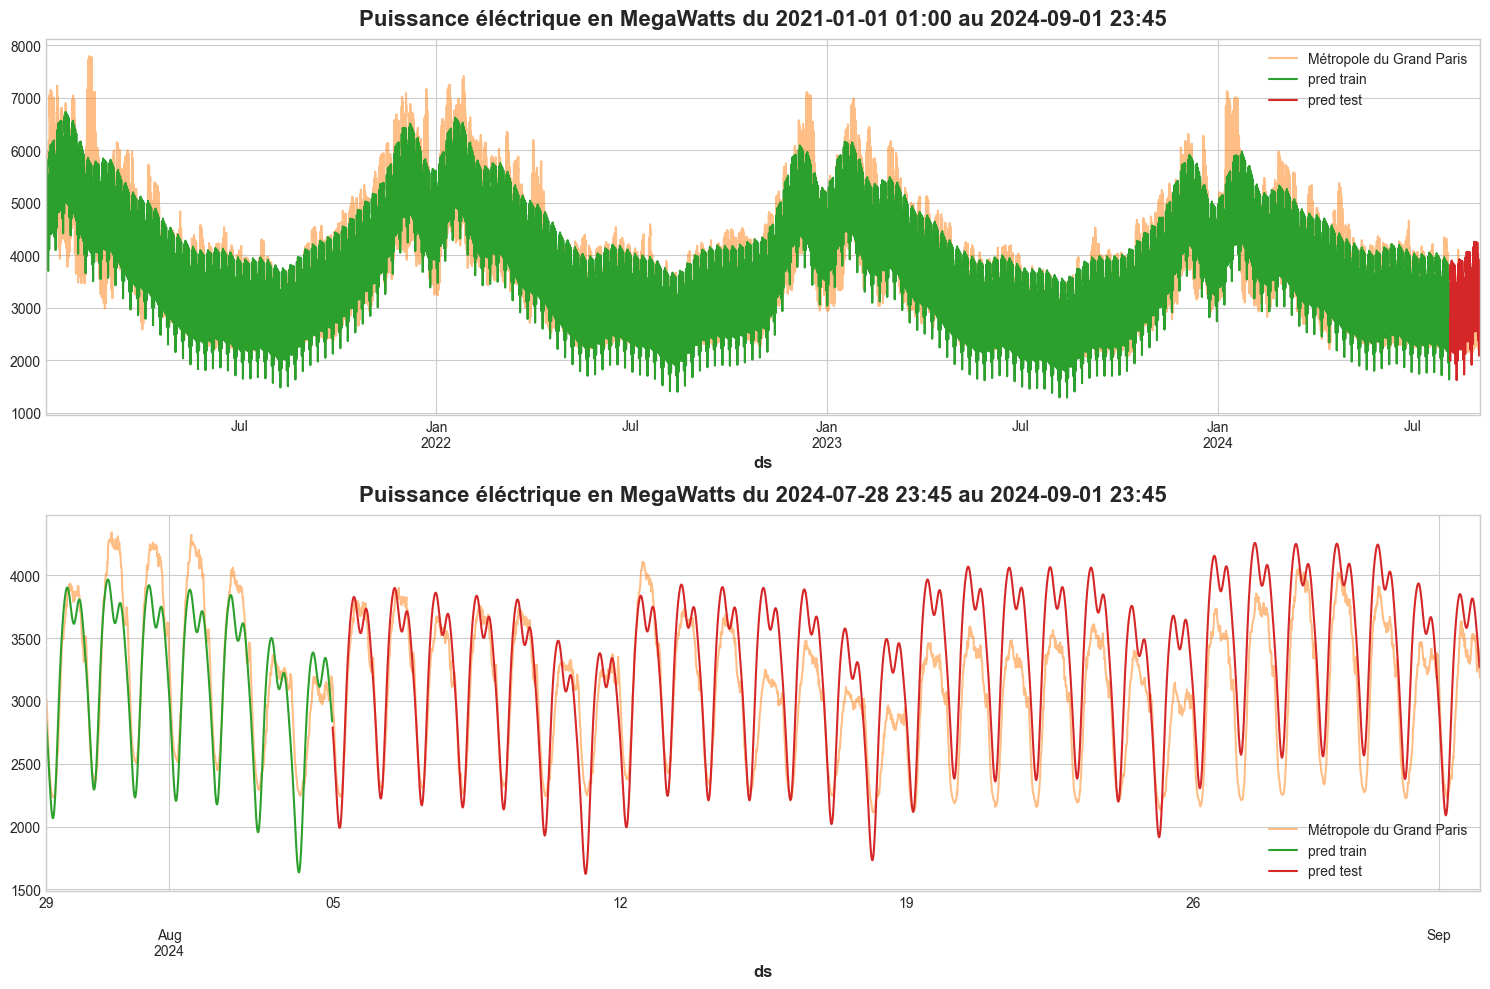

In [73]:
# Metriques 
metrics_train = evaluation_metrics(y=prophet_train.y , y_pred=prophet_pred_train)
metrics_test = evaluation_metrics(y=prophet_test.y , y_pred=prophet_pred_test)
print(f"Métriques sur Train : {metrics_train}")
print(f"Métriques sur Test : {metrics_test}")

# Affichage
plot_prediction(y_time, prophet_pred_train, prophet_pred_test)

La prédiction à l'aide de l'algorithme Prophet est moins bonne que nos prédictions précédentes. Nous ne retiendrons pas cette algorithme pour notre étude

## Prévision pour la fin d'année 2024

In [86]:
def plot_serie(y , title = "", startpred = None):   
    if startpred is not None : 
        train = y.loc[ : startpred]
        pred = y.loc[startpred :]
        ax = train.plot(color='C1' , label="données")
        pred.plot(ax = ax, color='C2' , label="prédiction")
    else :
        ax = y.plot()
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Puissance (MW)')
    ax.legend()
    return ax

In [90]:
xgb_model = XGBRegressor(n_estimators = 700, max_depth = 7, learning_rate = 0.01)

index_2024_pred  = pd.period_range(start=X_fourier.index[-1], end='2024-12-31 23:45', freq='15min')

X_2024_pred = dp_fourier.out_of_sample(steps=len(index_2024_pred))

X_2024_pred = create_feature(X_2024_pred)

xgb_model.fit(X_fourier_feature, y_time)

y_2024_pred = pd.DataFrame(xgb_model.predict(X_2024_pred) , index=X_2024_pred.index , columns=['Predictions pour fin 2024'])

y_2024_pred.to_csv(data_dir / 'Consommation_Metropole_du_Grand_Paris_fin_2024.csv' , sep=';', header=True , index=True)

<Axes: title={'center': 'Consommation sur 2024'}, xlabel='Date', ylabel='Puissance (MW)'>

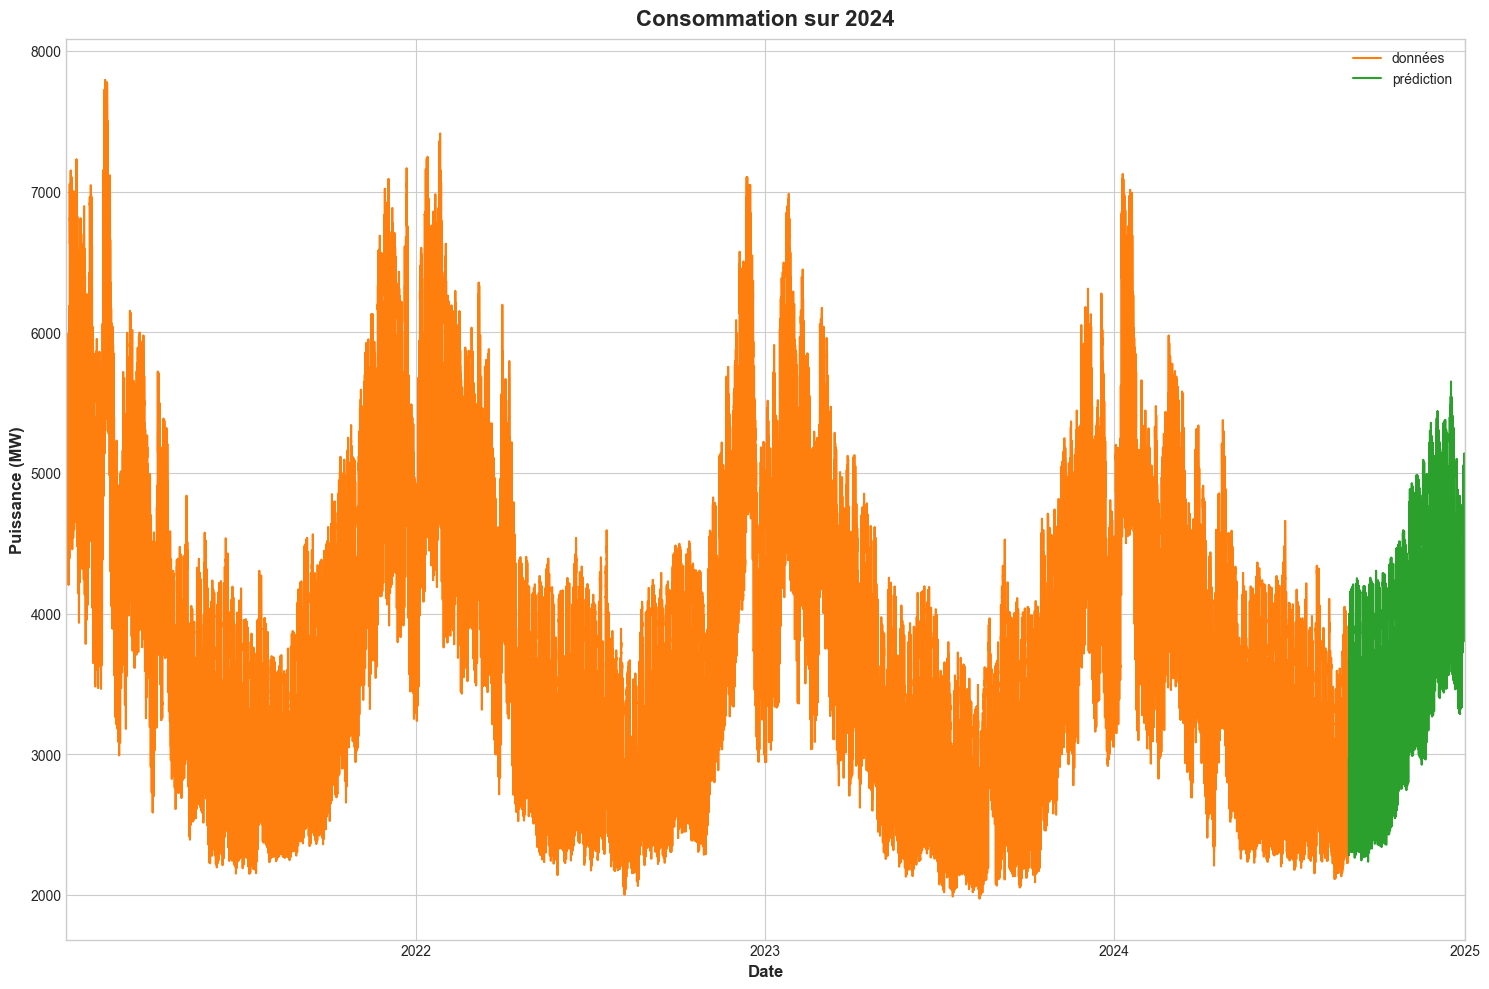

In [94]:
y_2024 = pd.concat((y_time.squeeze() , y_2024_pred.squeeze()))
plot_serie(y_2024, title="Consommation sur 2024", startpred=index_2024_pred[1])

<Axes: title={'center': 'Prévision pour fin 2024'}, xlabel='Date', ylabel='Puissance (MW)'>

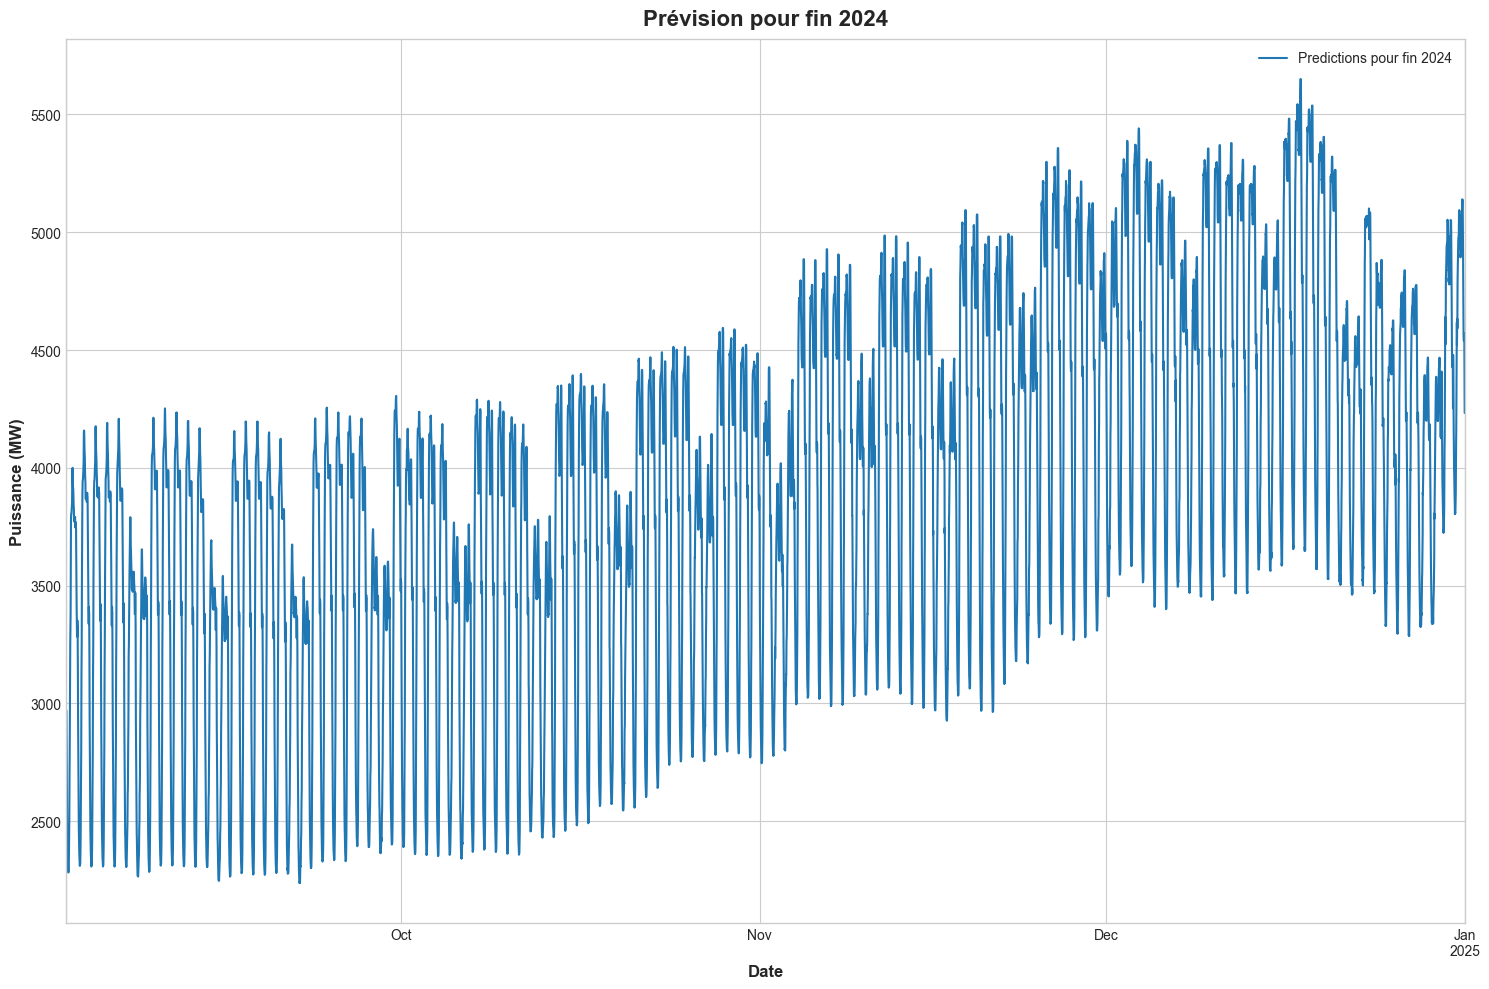

In [87]:
plot_serie(y_2024_pred, title="Prévision pour fin 2024")